In [1]:
import numpy as np
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from collections import Counter
from sklearn.metrics import confusion_matrix
import pandas as pd
import itertools
from sklearn.preprocessing import LabelEncoder


In [18]:
import os
from PIL import Image

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),        # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),   # Crop the center 224x224 pixels
    transforms.ToTensor()        # Convert the image to a PyTorch tensor
])
batch_size = 128
data_dir = '~/6895_Visual_Sentiment_Prediction/dataset'
dataset = datasets.ImageFolder(data_dir, transform=transform)
# train_dataset = datasets.ImageFolder('~/Desktop/6895/Images/train/', transform=transform)
# valid_dataset = datasets.ImageFolder('~/Desktop/6895/Images/validation/', transform=transform)
total_count = len(dataset)
train_count = int(0.7 * total_count) 
valid_count = total_count - train_count 
train_dataset, valid_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[train_count, valid_count])
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, shuffle = False) 
dataloaders = {'train': train_dataset_loader, 'valid': valid_dataset_loader}

In [11]:
def train_model(model, dataloaders, criterion, optimizer,device, num_epochs=50):
    since = time.time()
    best_acc = 0
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    test_acc_history = []
    train_losses = []
    valid_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        SAVE_PATH = os.path.join("models", 'm' + ".pt")
        torch.save(model, SAVE_PATH)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

          
            for inputs, labels in dataloaders[phase]:
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

           
                optimizer.zero_grad()
            
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
               
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
   
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
            


    return model, val_acc_history, train_acc_history,valid_losses, train_losses


# define plot accuracy and loss
def plot_acc_loss(val_acc_history, train_acc_history,valid_losses, train_losses):
    val_acc=[]
    for i in val_acc_history:
        val_acc.append(i.cpu().data.numpy())
    train_acc=[]
    for i in train_acc_history:
        train_acc.append(i.cpu().data.numpy())
    test_acc=[]

  
    plt.subplot(1,2,1)
    plt.plot(range(len(val_acc)),val_acc,label='val_acc')
    plt.plot(range(len(train_acc)),train_acc,label='train_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(range(len(valid_losses)),valid_losses,label='val_loss')
    plt.plot(range(len(train_losses)),train_losses,label='train_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

Epoch 0/9
----------
train Loss: 3.0262 Acc: 0.1124
valid Loss: 2.7267 Acc: 0.2378
Epoch 1/9
----------
train Loss: 2.5694 Acc: 0.2553
valid Loss: 2.4051 Acc: 0.3254
Epoch 2/9
----------
train Loss: 2.2549 Acc: 0.3607
valid Loss: 2.1740 Acc: 0.3751
Epoch 3/9
----------
train Loss: 2.0195 Acc: 0.4125
valid Loss: 1.9860 Acc: 0.4099
Epoch 4/9
----------
train Loss: 1.8138 Acc: 0.4617
valid Loss: 1.8487 Acc: 0.4341
Epoch 5/9
----------
train Loss: 1.6519 Acc: 0.5048
valid Loss: 1.7497 Acc: 0.4586
Epoch 6/9
----------
train Loss: 1.5118 Acc: 0.5388
valid Loss: 1.6731 Acc: 0.4709
Epoch 7/9
----------
train Loss: 1.3748 Acc: 0.5875
valid Loss: 1.6194 Acc: 0.4879
Epoch 8/9
----------
train Loss: 1.2611 Acc: 0.6216
valid Loss: 1.5800 Acc: 0.4889
Epoch 9/9
----------
train Loss: 1.1329 Acc: 0.6742
valid Loss: 1.5503 Acc: 0.4957


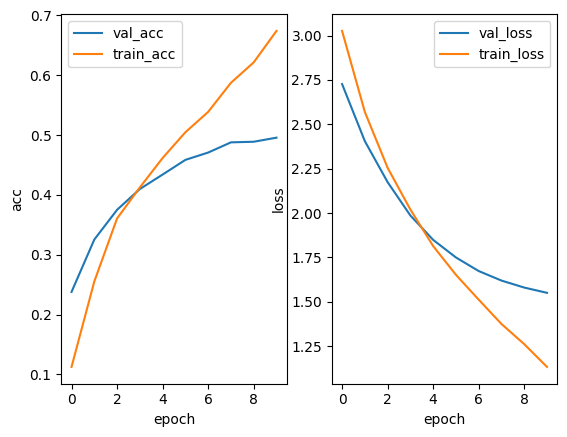

In [44]:
model = models.resnet50(pretrained = True) # Use the resnet18 model
num_ftrs = model.fc.in_features # Modify the number of model categories
model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, 24))


device = torch.device('cuda')
cost_fun = nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5) 
model = model.to(device = 'cuda', dtype = torch.float32)
model, val_acc_history, train_acc_history,valid_losses, train_losses = train_model(model, dataloaders, cost_fun, optimizer, device,num_epochs=10)
plot_acc_loss(val_acc_history, train_acc_history,valid_losses, train_losses)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x467 at 0x7F459AD4A550>


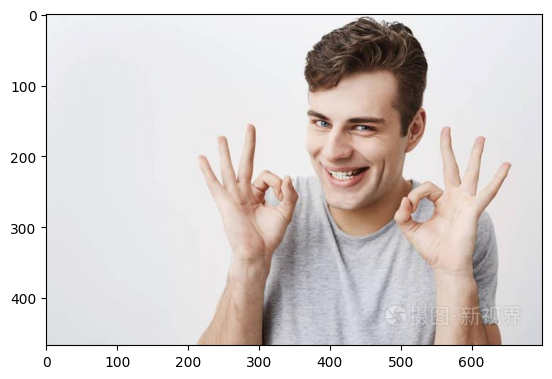

Anger
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=558x500 at 0x7F459B81AE10>


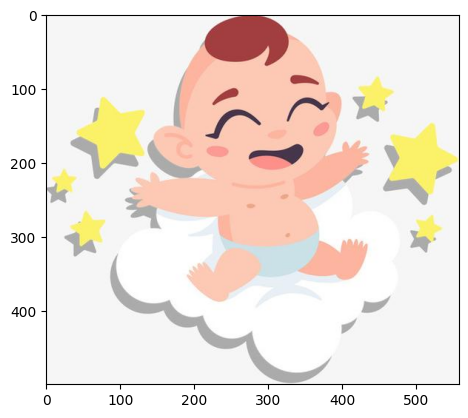

Anger
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7F459B1063D0>


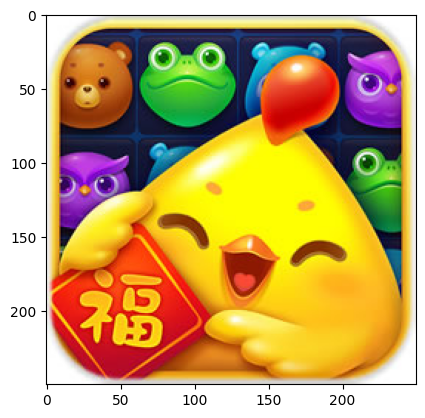

Surprise
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=952x952 at 0x7F459B1DC750>


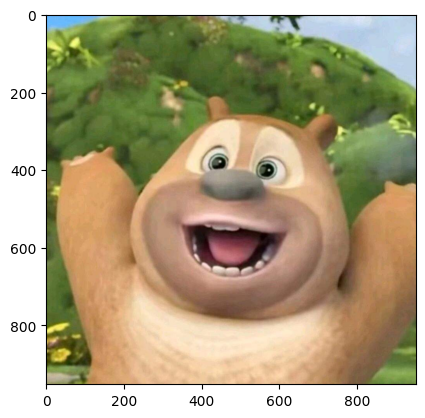

Surprise
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x200 at 0x7F459B048950>


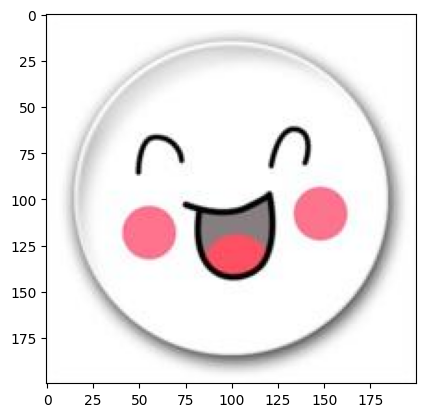

Boredom
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=610x548 at 0x7F44EC023B90>


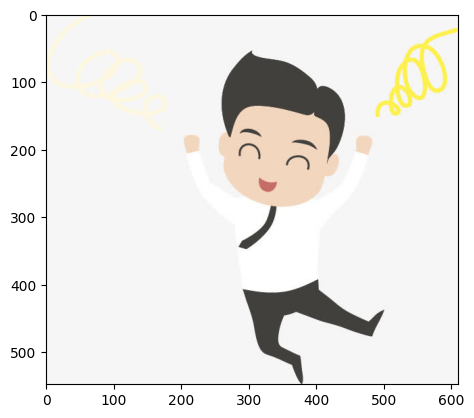

Anger
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1198x804 at 0x7F459AE25690>


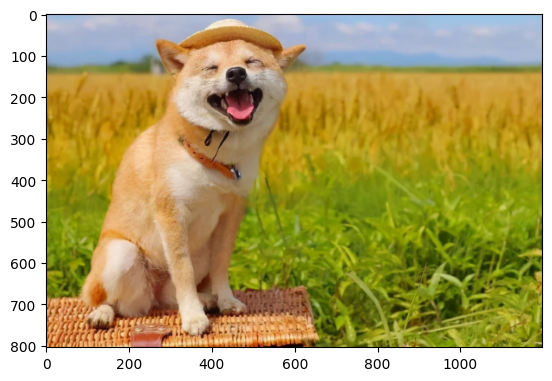

Joy
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=330x330 at 0x7F44ED120150>


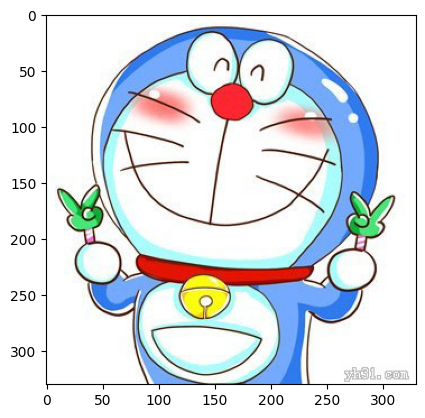

Surprise


In [59]:
PATH = os.path.join("models", 'm1' + ".pt")
model = torch.load(PATH).to('cpu')
# model = model.to('cpu')
model.eval()

test_transforms = transforms.Compose([
    transforms.Resize(256),        # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),   # Crop the center 224x224 pixels
    transforms.ToTensor()        # Convert the image to a PyTorch tensor
])
# example_image = 'predict/effbcb22132fa3380792c07f3f3459bd.jpeg'
# image = Image.open(example_image)

test_dir = 'predict'

# List all the files in the directory
files = os.listdir(test_dir)
i = 0


# train_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, shuffle = True)
# for inputs, labels in train_dataset_loader:
#     output = model(inputs)
#     label_map = ['Aggressiveness', 'Anger', 'Awe', 'Boredom', 'Disgust', 'Envy', 'Fear', 'Guilt', 
#                  'Irritation', 'Joy', 'Love', 'Sadness', 'Serenity', 'Shame', 'Surprise', 'Trust']
#     print(label_map[np.argmax(output.detach().numpy())], label_map[labels.item()])

# Iterate over each file and open/print it
for file in files:
#     if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
    image_path = os.path.join(test_dir, file)
    with Image.open(image_path) as image:
        print(image)
        plt.imshow(np.asarray(image))
#         plt.title(predicted_label)
        plt.show()
        i = i + 1
        if i > 10:
            break

        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        output = model(image_tensor)
        label_map = ['Aggressiveness', 'Anger', 'Awe', 'Boredom', 'Disgust', 'Envy', 'Fear', 'Guilt', 
                     'Irritation', 'Joy', 'Love', 'Sadness', 'Serenity', 'Shame', 'Surprise', 'Trust']
        print(label_map[np.argmax(output.detach().numpy())])
# print(dataset.classes)